# Hill Climbing

---

This notebook will train an Agent to solve the OpenAI Gym [Cartpole](https://gym.openai.com/envs/CartPole-v0/) environment using vanilla hill climbing. This is a
policy based method used to find the optimal policy. [Here](https://en.wikipedia.org/wiki/Hill_climbing) is an explanation of
the hill climbing optimization technique. Based on its simplicity, and the fact it could get stuck in local maximums,
I expect this algorithm to have stability issues. I will test this by running the simulations with different
random seeds and see how the results differ. All results will be saved in the saved_scores directory and can be viewed in
the images directory. Also comparisons between agents can be seen by using the comparisons.ipynb.

### 1. Import the Necessary Packages

In [8]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *

### 2. Define the Policy Network
The policy network is what we use to transform the state into a policy. For vanilla hill climbing this is a very simple linear
function that is then ran through a softmax function to generate probabilities. For Vanilla Hill Climbing this policy will
be deterministic and choose the max probability over all its action probabilities.

In [9]:
class Policy():
    """ Policy Represented as Neural Network """
    def __init__(self, env, seed=0):
        """ Initialize everything you need to run the policy. Note if you want different random starts for the original
        weights you need to change the seed when creating the Policy.

        :param env: environment this policy will be representing
        :param seed: for random weight generation
        """
        np.random.seed(seed)
        self.env = env
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.w = 0.0001*np.random.rand(self.state_space, self.action_space)  # weights for simple linear policy: state_space x action_space
        
    def forward_pass(self, state):
        x = np.dot(state, self.w)
        return np.exp(x)/sum(np.exp(x)) #softmax
    
    def get_action(self, state):
        probs = self.forward_pass(state)
        #action = np.random.choice(2, p=probs) # option 1: stochastic policy
        action = np.argmax(probs)              # option 2: deterministic policy
        return action

### 3. Train the Agent a single time with Vanilla Hill Climbing
This is a single simulation of the Vanilla Hill Climbing algorithm. The results probably will differ wildly every time you
run this because this is a very unstable learning algorithm. Note that the simulation will be over when the environment is solved. (Average Score of 100 episodes > 195)

In [10]:
env = gym.make('CartPole-v0')
policy = Policy(env=env, seed=0)

def hill_climbing(n_episodes=2000, max_t=1000, gamma=1.0, print_every=100, noise_scale=0.01):
    """Implementation of Single Vanilla Hill Climbing

    :param n_episodes: max number of training episodes
    :param max_t: max number of timesteps per episode
    :param gamma: discount rate
    :param print_every: how often to print average score
    :param noise_scale: std deviation of additive noise
    :return: list of scores from the episodes
    """
    scores_deque = deque(maxlen=100)
    scores = []
    best_reward = -np.Inf
    best_weights = policy.w
    for i_episode in range(1, n_episodes+1):
        rewards = []

        #Single Episode Run to done or max_timestep
        state = env.reset()
        for t in range(max_t):
            action = policy.get_action(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        # Store results of Single Episode
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        #Calculate Discounted Reward
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        # Update Network Weights for next Episode
        if R >= best_reward: # found better weights
            best_reward = R
            best_weights = policy.w
            policy.w += noise_scale * np.random.rand(*policy.w.shape)
        else: # did not find better weights
            policy.w = best_weights + noise_scale * np.random.rand(*policy.w.shape)

        # Show results during simulation
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0 and i_episode > 99:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            policy.w = best_weights
            break
        
    return scores
            
scores = hill_climbing()

Episode 100	Average Score: 86.62
Episode 200	Average Score: 114.83
Episode 300	Average Score: 145.62
Episode 400	Average Score: 148.08
Episode 500	Average Score: 165.05
Episode 600	Average Score: 152.09
Episode 700	Average Score: 137.37
Episode 800	Average Score: 176.45
Episode 900	Average Score: 170.10
Episode 1000	Average Score: 158.93
Episode 1100	Average Score: 115.81
Episode 1200	Average Score: 178.34
Episode 1300	Average Score: 158.91
Episode 1400	Average Score: 164.07
Episode 1500	Average Score: 131.31
Environment solved in 1488 episodes!	Average Score: 195.57


### 4. Plot Single Simulation Scores
The results of a single simulation do not tell us much but we can usually see that the variance between episodes is extremely high.

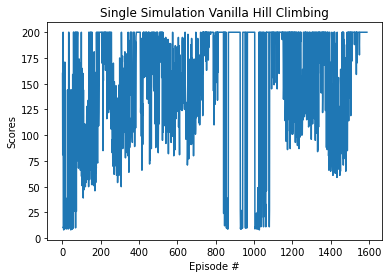

In [11]:
def graph_single(scores, save_graph=True):
    fig, ax = plt.subplots()
    ax.set(xlabel="Episode #", ylabel="Scores", title="Single Simulation Vanilla Hill Climbing")
    plt.plot(np.arange(1, len(scores)+1), scores)
    if save_graph:
        filepath = f"C:\Dev\Python\RL\Policy-Based-Methods\images\\vanilla_HillClimbing_single.png"
        fig.savefig(filepath)
    plt.show()

graph_single(scores)

### 5. Run Multiple Simulations to see Agent Stability
The goal of this section is to run the agent many times threw the environment and plot how long it takes it to solve the environment.
This should give us a good idea of the stability of the algorithm.

In [12]:
def hill_climbing_multiple(num_sims= 1000, n_episodes=2000, max_t=1000, gamma=1.0, print_every=100, noise_scale=0.01):
    """Implementation of Multiple Vanilla Hill Climbing Simulations with different seed

    :param num_sims: number of simulations to run
    :param n_episodes: max number of training episodes
    :param max_t: max number of timesteps per episode
    :param gamma: discount rate
    :param print_every: how often to print average score
    :param noise_scale: std deviation of additive noise
    :return: list of ints of how long it took to solve environment
    """

    solved = [] #keep track of when environment was solved
    env = gym.make('CartPole-v0')

    for sim in range(num_sims):
        #Setup everything (new seed each time)
        policy = Policy(env=env, seed=sim)
        scores_deque = deque(maxlen=100)
        scores = []
        best_reward = -np.Inf
        best_weights = policy.w

        for i_episode in range(1, n_episodes+1):
            rewards = []
            #Single Episode Run to done or max_timestep
            state = env.reset()
            for t in range(max_t):
                action = policy.get_action(state)
                state, reward, done, _ = env.step(action)
                rewards.append(reward)
                if done:
                    break
            # Store results of Single Episode
            scores_deque.append(sum(rewards))
            scores.append(sum(rewards))

            #Calculate Discounted Reward
            discounts = [gamma**i for i in range(len(rewards)+1)]
            R = sum([a*b for a,b in zip(discounts, rewards)])
            # Update Network Weights for next Episode
            if R >= best_reward: # found better weights
                best_reward = R
                best_weights = policy.w
                policy.w += noise_scale * np.random.rand(*policy.w.shape)
            else: # did not find better weights
                policy.w = best_weights + noise_scale * np.random.rand(*policy.w.shape)

            # Checking if solved and saving when it was solved
            if np.mean(scores_deque)>=195.0 and i_episode > 99:
                solved.append(i_episode)
                policy.w = best_weights
                break
            # Didn't solve
            if i_episode == n_episodes:
                solved.append(i_episode)

    return solved

solved = hill_climbing_multiple()
write_scores("HillClimbing_Solved", solved)

### 6. Plot Multiple Simulation Scores
This graph gives us a good idea of how stable the algorithm is. The high frequency at 2000 is mostly episodes that did
not solve the environment.

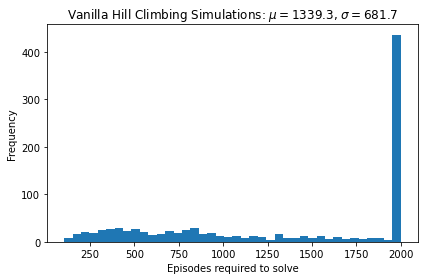

In [13]:
def graph_multiple(scores, save_graph=True):
    # Calculate the Mean and Standard Deviation of the scores
    mean = round(np.mean(scores),1)
    std = round(np.std(scores),1)

    # Graph the Results
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(scores, 40)
    ax.set(xlabel="Episodes required to solve", ylabel="Frequency", title=f"Vanilla Hill Climbing Simulations: $\mu={mean}$, $\sigma={std}$")
    fig.tight_layout()

    # Save the Graph
    if save_graph:
        filepath = f"C:\Dev\Python\RL\Policy-Based-Methods\images\\vanilla_HillClimbing_multiple.png"
        fig.savefig(filepath)

    plt.show()

scores = load_scores(f"C:\Dev\Python\RL\Policy-Based-Methods\saved_scores\HillClimbing_Solved.txt")
graph_multiple(scores)


### 7. Watch a Smart Agent!

In [14]:
env = gym.make('CartPole-v0')
state = env.reset()
for t in range(200):
    action = policy.get_action(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()